In [ ]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Define the label mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # 숫자
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',  # 대문자
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',  # 대문자
    'U', 'V', 'W', 'X', 'Y', 'Z',                     # 대문자
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'  # 소문자
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 224x224로 조정
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# dataset 분할 (test:validation = 5:1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# Convert integer labels to character labels
def convert_labels_to_characters(labels, label_mapping):
    return np.array([label_mapping[label] for label in labels])

###### 바꾼 코드
y_train = to_categorical(y_train, num_classes=47)
y_valid = to_categorical(y_valid, num_classes=47)
y_test = to_categorical(y_test, num_classes=47)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

In [ ]:
# 데이터셋 확인
print(ds_info)
print(dataset)
print(train_dataset)
print(valid_dataset)
print(test_dataset)
print("훈련 데이터셋 크기:", len(X_train))
print("검증 데이터셋 크기:", len(X_valid))
print("테스트 데이터셋 크기:", len(X_test))

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/root/tensorflow_datasets/emnist/balanced/3.1.0',
    file_format=array_record,
    download_size=535.73 MiB,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    supervis

AttributeError: 'numpy.ndarray' object has no attribute 'decode'

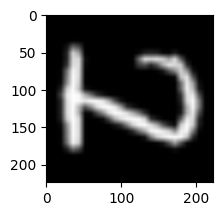

In [ ]:
# Function to display images with their labels
def display_images_with_labels(dataset, num_images=12):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(labels[i].numpy().decode('utf-8'))
            plt.axis("off")

# Display some images from the training set
display_images_with_labels(train_dataset)
plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

num_classes = 47
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer=keras.optimizers.adam,
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [ ]:
modelL = LeNet((28,28,1), num_classes)

modelL.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,851 (253.32 KB)

 Trainable params: 64,851 (253.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = modelL.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4821 - loss: 1.9227 - val_accuracy: 0.8209 - val_loss: 0.5268
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7900 - loss: 0.6498 - val_accuracy: 0.8332 - val_loss: 0.4899
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8195 - loss: 0.5557 - val_accuracy: 0.8482 - val_loss: 0.4469
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8311 - loss: 0.5123 - val_accuracy: 0.8541 - val_loss: 0.4321
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8423 - loss: 0.4785 - val_accuracy: 0.8538 - val_loss: 0.4401
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8471 - loss: 0.4590 - val_accuracy: 0.8543 - val_loss: 0.4556
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8522 - loss: 0.4426 - val_accuracy: 0.8544 - val_loss: 0.4575
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8545 - loss: 0.4246 

In [ ]:
modelL.save("LeNet_medel.h5")

In [ ]:
# Common imports
import numpy as np
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Saving figure LeNet_learning_curves_plot


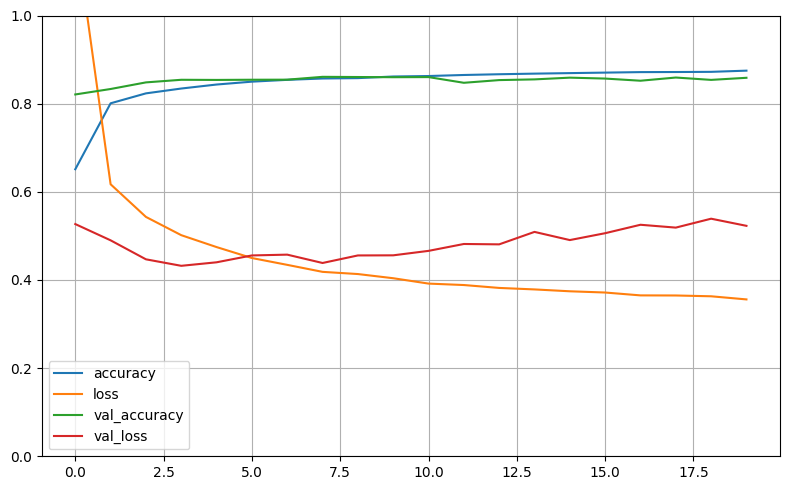

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("LeNet_learning_curves_plot")
plt.show()

In [ ]:
# evaluate
modelL_test = modelL.evaluate(X_test, y_test)
print("modelL:", modelL_test)

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8550 - loss: 0.5433
MSE: [0.5449225902557373, 0.8559574484825134]


In [ ]:
# predict
X_new = X_test[:3]
y_pred = modelL.predict(X_new)
print("예측 결과:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
예측 결과: [[6.14675386e-08 1.75207410e-13 5.06995093e-05 3.27492145e-10
  4.13383168e-05 1.66039329e-14 2.29569022e-13 2.60542338e-10
  4.90887082e-08 2.04010517e-03 1.32487115e-08 6.05398164e-13
  6.75227563e-09 5.34974820e-09 1.64442390e-10 1.25072478e-11
  1.95568589e-07 8.56190729e-10 2.61363597e-10 7.36396988e-09
  2.40884209e-17 5.62429658e-10 4.74689212e-11 1.20233445e-09
  3.27087082e-06 1.37487257e-13 2.79999047e-04 4.11798950e-09
  1.17718654e-10 4.75837699e-15 2.00307059e-05 1.09016062e-12
  6.14863804e-09 1.30774612e-12 2.71987901e-05 2.11905513e-06
  7.97209203e-01 8.92378449e-10 3.01362206e-07 3.60809906e-07
  2.83036060e-11 1.46295503e-01 8.80694184e-10 2.38641888e-07
  5.40292412e-02 1.92570061e-14 6.34726022e-11]
 [7.11330409e-14 3.24281942e-20 3.37327619e-14 1.08806453e-12
  1.48696522e-29 1.03007435e-12 3.01033540e-15 5.78550243e-25
  7.15879594e-07 3.69545110e-23 2.90705397e-21 9.99920607e-01
  5.03011477e-19 2.56861393e-10 9.3048

In [ ]:
# activation function 'tanh'
tf.random.set_seed(42)
np.random.seed(42)

num_classes = 47
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='tanh',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='tanh',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='tanh',
                    padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='tanh'))
    self.add(Dropout(0.5))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer='adam', learning_rate=1e-3
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [ ]:
modelL_tanh = LeNet((28,28,1), num_classes)

history = modelL.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8738 - loss: 0.3525 - val_accuracy: 0.8570 - val_loss: 0.5276
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8732 - loss: 0.3606 - val_accuracy: 0.8593 - val_loss: 0.5253
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8739 - loss: 0.3500 - val_accuracy: 0.8607 - val_loss: 0.5361
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8751 - loss: 0.3536 - val_accuracy: 0.8607 - val_loss: 0.5374
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8761 - loss: 0.3491 - val_accuracy: 0.8611 - val_loss: 0.5443
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8761 - loss: 0.3502 - val_accuracy: 0.8573 - val_loss: 0.5575
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8762 - loss: 0.3440 - val_accuracy: 0.8548 - val_loss: 0.5809
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8776 - loss: 0.3432 

In [ ]:
modelL.save("LeNet_tanh_medel.h5")

Saving figure LeNet_tanh_learning_curves_plot


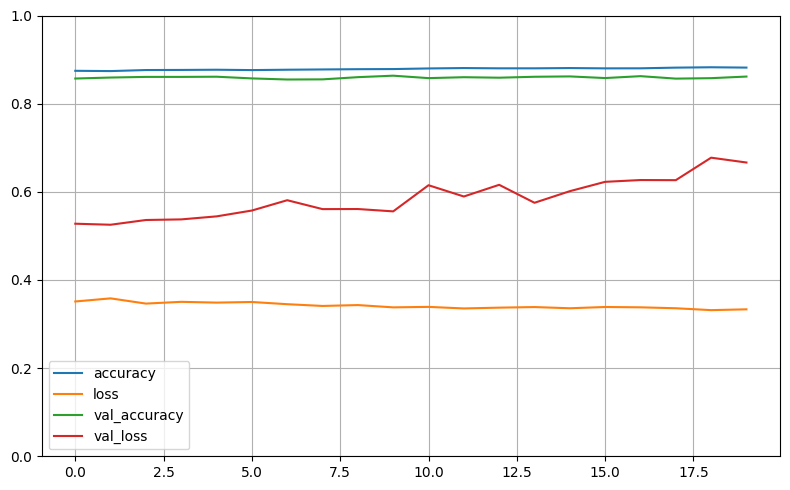

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("LeNet_tanh_learning_curves_plot")
plt.show()

In [ ]:
# learning rate, relu
tf.random.set_seed(42)
np.random.seed(42)

learning_rate=1e-3

num_classes = 47
optimizer = tf.keras.optimizers.Adam(learning_rate)
class LeNetlr(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer=optimizer,
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [ ]:
modellr = LeNetlr((28,28,1), num_classes)

history = modellr.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.4830 - loss: 1.9806 - val_accuracy: 0.8273 - val_loss: 0.5023
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7967 - loss: 0.6394 - val_accuracy: 0.8447 - val_loss: 0.4518
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8242 - loss: 0.5444 - val_accuracy: 0.8509 - val_loss: 0.4457
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8361 - loss: 0.5003 - val_accuracy: 0.8535 - val_loss: 0.4322
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8454 - loss: 0.4670 - val_accuracy: 0.8550 - val_loss: 0.4364
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8518 - loss: 0.4428 - val_accuracy: 0.8572 - val_loss: 0.4311
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8535 - loss: 0.4296 - val_accuracy: 0.8559 - val_loss: 0.4422
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8595 - loss: 0.4137

In [ ]:
modellr.save("LeNetlr_medel.h5")

Saving figure LeNetlr_learning_curves_plot


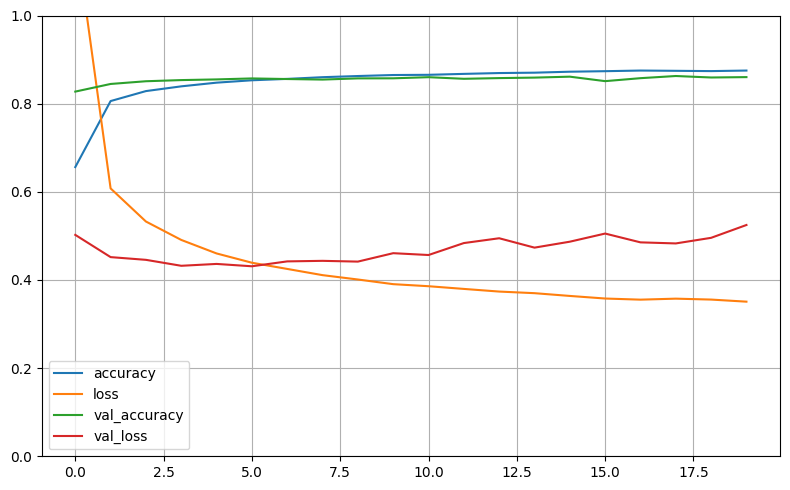

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("LeNetlr_learning_curves_plot")
plt.show()

In [ ]:
# learning rate, relu
tf.random.set_seed(42)
np.random.seed(42)

learning_rate=1e-5

num_classes = 47
optimizer = tf.keras.optimizers.Adam(learning_rate)
class LeNetlr(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer=optimizer,
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [ ]:
modellr_5 = LeNetlr((28,28,1), num_classes)

history = modellr_5.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.0338 - loss: 5.6505 - val_accuracy: 0.1666 - val_loss: 3.4131
Epoch 2/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1202 - loss: 3.4435 - val_accuracy: 0.3517 - val_loss: 2.7429
Epoch 3/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2209 - loss: 2.9979 - val_accuracy: 0.4796 - val_loss: 2.2232
Epoch 4/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.2991 - loss: 2.6479 - val_accuracy: 0.5600 - val_loss: 1.8728
Epoch 5/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3636 - loss: 2.3802 - val_accuracy: 0.6113 - val_loss: 1.6142
Epoch 6/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4143 - loss: 2.1710 - val_accuracy: 0.6473 - val_loss: 1.4182
Epoch 7/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4518 - loss: 2.0000 - val_accuracy: 0.6748 - val_loss: 1.2717
Epoch 8/30
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4826 - loss: 1.

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("LeNetlr_learning_curves_plot")
plt.show()

In [ ]:
# learning rate, relu
tf.random.set_seed(42)
np.random.seed(42)

learning_rate=1e-4

num_classes = 47
optimizer = tf.keras.optimizers.Adam(learning_rate)
class LeNetlr(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer=optimizer,
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [ ]:
modellr_4 = LeNetlr((28,28,1), num_classes)

history = modellr_4.fit(X_train, y_train, epochs=50,
                   validation_data=(X_valid, y_valid), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.1705 - loss: 3.5375 - val_accuracy: 0.6920 - val_loss: 1.1349
Epoch 2/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5567 - loss: 1.5384 - val_accuracy: 0.7757 - val_loss: 0.7255
Epoch 3/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6811 - loss: 1.0559 - val_accuracy: 0.8084 - val_loss: 0.5897
Epoch 4/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7361 - loss: 0.8533 - val_accuracy: 0.8246 - val_loss: 0.5277
Epoch 5/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7682 - loss: 0.7400 - val_accuracy: 0.8339 - val_loss: 0.4891
Epoch 6/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7903 - loss: 0.6705 - val_accuracy: 0.8382 - val_loss: 0.4707
Epoch 7/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8054 - loss: 0.6132 - val_accuracy: 0.8447 - val_loss: 0.4556
Epoch 8/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8144 - loss: 0.5

Saving figure LeNetlr_learning_curves_plot


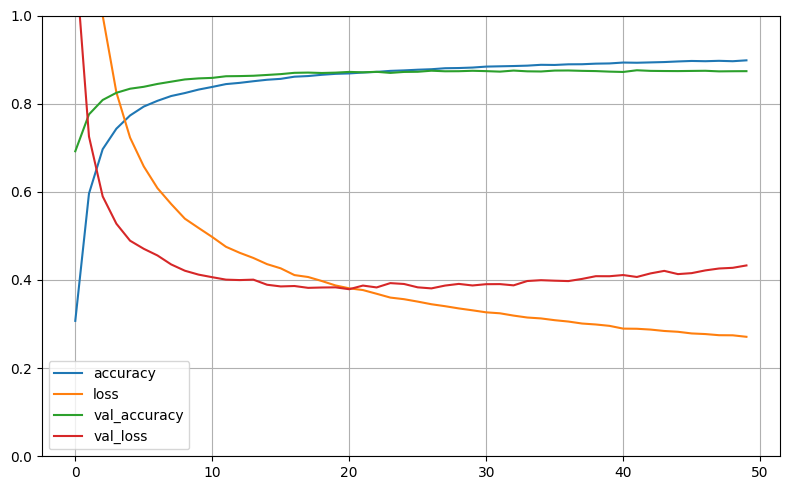

In [ ]:
modellr.save("LeNetlr4_medel.h5")

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("LeNetlr_learning_curves_plot")
plt.show()